# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks
from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler
import xarray as xr
from klearn_tcyclone.models_utils import predict_time_series
from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import TCTracks_from_TensorContextDataset


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-29 20:18:06,794 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


### Normalise data

In [3]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [4]:
scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8070, 42, 3): 8070 contexts of length 42 with 3 features each
Test contexts have shape (1029, 42, 3): 1029 contexts of length 42 with 3 features each


### Predict time series and plot in original coordinates

In [5]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [6]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [7]:
model, fit_time = timer(model.fit)(contexts['train'])

Select a random collection of time series in the test context and predict `n_steps = 10` steps into the future.

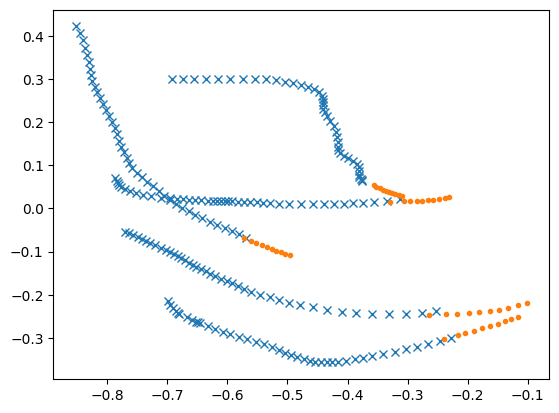

In [8]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")

Looks good. To visualize the tropical cyclone tracks and the predictions on the acutal map, we have to scale both back to the original coordinate system.

In [9]:
# #TODO The following generates TensorContextDatasets with smaller context length. This cannot be used as input to prediction for now.
# idx = np.random.randint(0, contexts["train"].shape[0])
# initial_context_arr = contexts['train'].data[:idx,:10]
# print(initial_context_arr.shape)
# print(type(initial_context_arr))
# initial_context = TensorContextDataset(initial_context_arr)
# print(initial_context.shape)
# print(type(initial_context))
# ts = predict_time_series(model, initial_context, n_steps=13)

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

In [10]:
idx = np.random.randint(0, contexts["test"].shape[0], 20)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

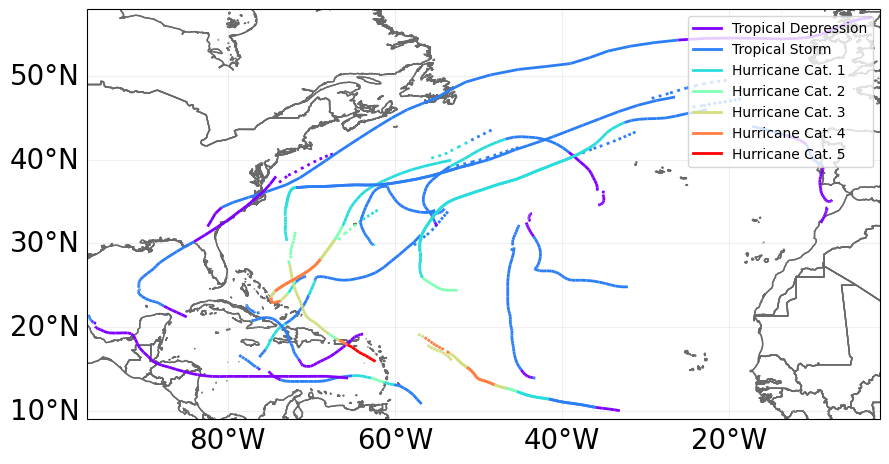

In [11]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)
test_context_tc_tracs = TCTracks_from_TensorContextDataset(test_context_scaled, feature_list=feature_list)
predicted_context_tc_tracs = TCTracks_from_TensorContextDataset(predicted_context_scaled, feature_list=feature_list)

ax = predicted_context_tc_tracs.plot(linestyle="dotted")
_ = test_context_tc_tracs.plot(axis=ax, linestyle="solid")

Looks good, but arguably, the predictions of the model are not yet very good. This needs to be optimized!

In [1]:
import os
import random
import time

import numpy as np
import torch
from absl import app
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from klearn_tcyclone.training_utils.training_utils import get_default_flag_values
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.models import Koopman
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.training_utils.training_utils import set_flags
from absl import app, flags

In [2]:
from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

In [3]:
loss_fun = nn.MSELoss()

Set some specific parameters and load default values for all other parameters.

In [4]:
flag_params = {
    "koopman_kernel_num_train_stops": 5,
    "year_range": [1990, 2000],
    "model": "Nystroem_RRR",
}
flag_params = extend_by_default_flag_values(flag_params)

In [5]:
flag_params["model"]

'Nystroem_RRR'

In [6]:
current_file_dir_path = os.getcwd()
import_dir = os.path.join(
    current_file_dir_path,
    "../train_models/"
    "training_results",
    "{}_yrange{}".format(
        flag_params["dataset"],
        "".join(map(str,flag_params["year_range"])),
    ),
    flag_params["model"],
)

In [7]:
import_dir

'c:\\Users\\Eric\\Projects\\koopman_learning_tropical_cyclone\\examples\\../train_models/training_results\\TCTracks_yrange19902000\\Nystroem_RRR'

In [8]:
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)

In [9]:
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()
eval_metric = RMSE_OneStep_TCTracks

# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=flag_params["year_range"],
    basin="NA",
    correct_pres=False,
)

# TODO include random_state = seed in train_test_split
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1, random_state=flag_params["seed"])

Device cuda


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-02 11:19:57,991 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-02 11:19:59,219 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 1990145N19276, 1990262N15315, 1991187N23264, 1991241N11329.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [10]:
model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}".format(
    flag_params["seed"],
    flag_params["koopman_kernel_length_scale"],
    flag_params["koopman_kernel_rank"],
    flag_params["koopman_kernel_reduced_rank"],
    flag_params["tikhonov_reg"],
    flag_params["koopman_kernel_num_centers"],
    flag_params["koopman_kernel_num_train_stops"],
    flag_params["context_length"],
)

results_file_name = os.path.join(import_dir, model_name)

In [11]:
results_file_name

'c:\\Users\\Eric\\Projects\\koopman_learning_tropical_cyclone\\examples\\../train_models/training_results\\TCTracks_yrange19902000\\Nystroem_RRR\\seed123_kklnscale50.0_kkrank25_kkrdrankTrue_kktkreg1e-06_kkncntr250_kkntstops5_kkcntlength42'

In [12]:
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from matplotlib import pyplot as plt

In [13]:
benchmark = ModelBenchmark(
    feature_list,
    tc_tracks_train,
    tc_tracks_test,
    scaler=scaler,
    context_length=flag_params["context_length"],
)

benchmark._standardize_data()

contexts = {
    "train": benchmark.tensor_context_train,
    "test": benchmark.tensor_context_test,
}

training_data_size = contexts["train"].shape[0]
# TODO check what happens if for each stop in training_stops, the model is initialized from scratch
train_stops = np.logspace(
    2.5, np.log10(training_data_size), flag_params["koopman_kernel_num_train_stops"]
).astype(int)

In [14]:
train_stops

array([ 316,  554,  973, 1707, 2995])

In [15]:
rmse = []
fit_times = []
for stop in train_stops:
    print(stop)
    # model, train_stop, eval_rms
    res= torch.load(
        results_file_name + f"_train_steps{stop}" + ".pth",
    )
    rmse.append(res["eval_rmse"])
    fit_times.append(res["fit_time"])

316
554
973
1707
2995


C:\Users\Eric\AppData\Local\Temp\ipykernel_22312\517797448.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res= torch.load(


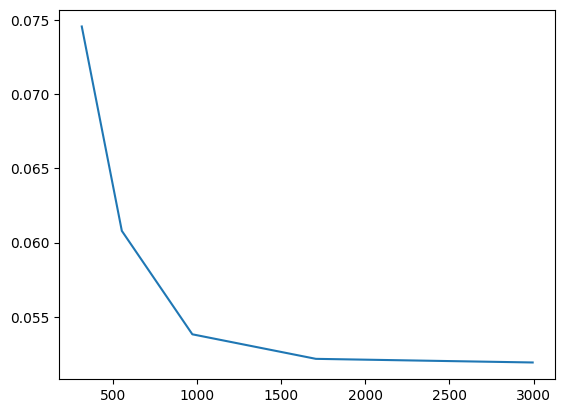

In [16]:
plt.plot(train_stops, rmse)
# plt.xscale("log")
# plt.yscale("log")

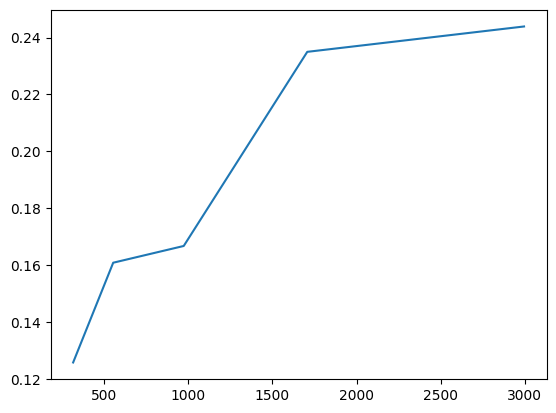

In [17]:
plt.plot(train_stops, fit_times)
# plt.xscale("log")
# plt.yscale("log")

In [18]:
best_result = torch.load(
    results_file_name + f"_best" + ".pth",
)

C:\Users\Eric\AppData\Local\Temp\ipykernel_22312\3224274684.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_result = torch.load(


In [19]:
model = best_result["model"]

In [20]:
from klearn_tcyclone.models_utils import predict_time_series
from matplotlib import pyplot as plt

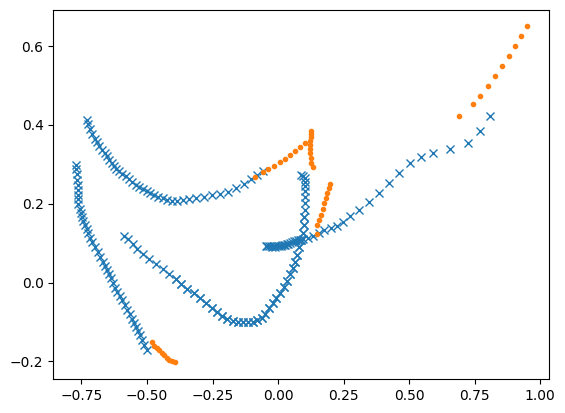

In [21]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")